In [1]:
import torch
import torch.utils.data
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import numpy as np
import h5py
from data_utils import get_data
import matplotlib.pyplot as plt

from solver_pytorch import Solver

In [2]:
# Load data from all .mat files, combine them, eliminate EOG signals, shuffle and 
# seperate training data, validation data and testing data.
# Also do mean subtraction on x.

data = get_data('project_datasets',num_validation=150, num_test=100)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (2308, 22, 1000) 
y_train: (2308,) 
X_val: (150, 22, 1000) 
y_val: (150,) 
X_test: (100, 22, 1000) 
y_test: (100,) 


In [3]:
# class flatten to connect to FC layer
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H = x.size() # read in N, C, H
        return x.view(N, -1)

In [4]:
# turn x and y into torch type tensor

dtype = torch.FloatTensor

X_train = Variable(torch.Tensor(data.get('X_train'))).type(dtype)
y_train = Variable(torch.Tensor(data.get('y_train'))).type(torch.IntTensor)
X_val = Variable(torch.Tensor(data.get('X_val'))).type(dtype)
y_val = Variable(torch.Tensor(data.get('y_val'))).type(torch.IntTensor)
X_test = Variable(torch.Tensor(data.get('X_test'))).type(dtype)
y_test = Variable(torch.Tensor(data.get('y_test'))).type(torch.IntTensor)

(Iteration 1 / 1150) loss: 1.466070
(Epoch 0 / 50) train acc: 0.262998; val_acc: 0.260000
(Epoch 1 / 50) train acc: 0.454073; val_acc: 0.286667
(Epoch 2 / 50) train acc: 0.563692; val_acc: 0.380000
(Iteration 51 / 1150) loss: 0.923351
(Epoch 3 / 50) train acc: 0.696707; val_acc: 0.466667
(Epoch 4 / 50) train acc: 0.813258; val_acc: 0.513333
(Iteration 101 / 1150) loss: 0.477949
(Epoch 5 / 50) train acc: 0.872617; val_acc: 0.520000
(Epoch 6 / 50) train acc: 0.913778; val_acc: 0.553333
(Iteration 151 / 1150) loss: 0.261262
(Epoch 7 / 50) train acc: 0.948440; val_acc: 0.533333
(Epoch 8 / 50) train acc: 0.970971; val_acc: 0.586667
(Iteration 201 / 1150) loss: 0.125258
(Epoch 9 / 50) train acc: 0.984835; val_acc: 0.526667
(Epoch 10 / 50) train acc: 0.987868; val_acc: 0.526667
(Iteration 251 / 1150) loss: 0.039260
(Epoch 11 / 50) train acc: 0.992634; val_acc: 0.546667
(Epoch 12 / 50) train acc: 0.996534; val_acc: 0.533333
(Epoch 13 / 50) train acc: 0.997400; val_acc: 0.526667
(Iteration 301 

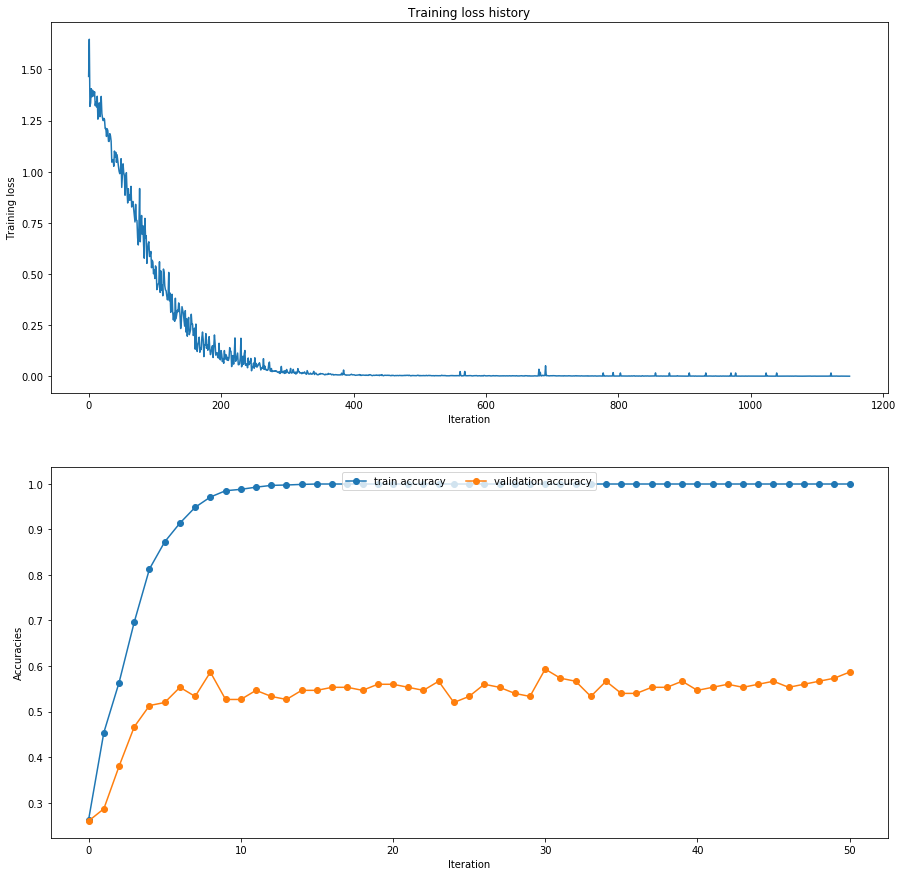

Accuracy on the validation set:  0.593333333333
parameters of the best model:
{}


In [5]:
# train a 1D convolutional neural network
# optimize hyper parameters
best_model = None
parameters =[] # a list of dictionaries
parameter = {} # a dictionary
best_params = {} # a dictionary
best_val_acc = 0.0

# hyper parameters in model
filter_num = 40

filter_sizes = [7]#, 5, 3]
pool_sizes = [4]#, 2]
drop_ps = [0.2]#, 0.5, 0.8]

# hyper parameters in solver
batch_sizes = [100]#, 200, 400]
lrs = [1e-3]#, 3.3e-4, 1e-4]


for filter_size in filter_sizes:
    for pool_size in pool_sizes:
        for drop_p in drop_ps:
            linear_size = int((X_test.shape[2]-filter_size))+1
            linear_size = int((linear_size-pool_size)/pool_size)+1
            linear_size *= filter_num
                
            for batch_size in batch_sizes:
                for lr in lrs:
                    model = nn.Sequential(
                        nn.Conv1d(22, filter_num, kernel_size=filter_size, stride=1),
                        nn.ReLU(inplace=True),
                        nn.Dropout(p=drop_p),
                        nn.BatchNorm1d(num_features=filter_num),
                        nn.MaxPool1d(kernel_size=pool_size, stride=pool_size),
                        Flatten(),
                        nn.Linear(linear_size, 20),
                        nn.ReLU(inplace=True),
                        nn.Linear(20, 4)
                    )
                    
                    model.type(dtype)
                    
                    solver = Solver(model, data,
                                    lr = lr, batch_size=batch_size,
                                    verbose=True, print_every=50)

                    solver.train()
                    
                    # save training results and parameters of neural networks
                    parameter['filter_num'] = filter_num
                    parameter['filter_size'] = filter_size
                    parameter['pool_size'] = pool_size
                    parameter['batch_size'] = batch_size
                    parameter['lr'] = lr
                    parameters.append(parameter)
                    
                    if solver.best_val_acc > best_val_acc:
                        best_val_acc = solver.best_val_acc
                        best_model = model
                        best_solver = solver
                        best_params = parameter
                        
# Plot the loss function and train / validation accuracies of the best model
plt.subplot(2,1,1)
plt.plot(best_solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')

plt.subplot(2,1,2)
plt.plot(best_solver.train_acc_history, '-o', label='train accuracy')
plt.plot(best_solver.val_acc_history, '-o', label='validation accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracies')
plt.legend(loc='upper center', ncol=4)

plt.gcf().set_size_inches(15, 15)
plt.show()

print('Accuracy on the validation set: ', best_val_acc)
print('parameters of the best model:')
print(best_params)


In [6]:
# test set
y_test_pred = model(X_test)
  
_, y_pred = torch.max(y_test_pred,1)
test_accu = np.mean(y_pred.data.numpy() ==  y_test.data.numpy())
print('Test accuracy', test_accu, '\n')   

Test accuracy 0.53 

